# Project Inscriptions -- Exploratory Data Analysis

**[Johnnatan Messias](https://johnnatan-messias.github.io) and [Krzysztof Gogol](https://www.linkedin.com/in/krzysztofgogol), February 2025**


In [1]:
import os
import polars as pl
import plotly.graph_objects as go

import requests
import pandas as pd

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(code_dir)

In [3]:
from plot_utils import get_plotly_layout
from plot_utils import colors
width, height = 800, 450

In [4]:
# Existing dataset dir
data_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "plots"))

# Existing plots dir
os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

## Exploratory Data Analysis


In [5]:
# Define the chain variables
chains = [
    'arbitrum',
    'base',
    'ethereum',
    # 'bsc',
    # 'fantom',
    'optimism',
    'zksync'
]

# Create a Polars DataFrame
chains_df = pl.DataFrame({"chain": chains})

# Print the DataFrame
print(chains_df)

shape: (5, 1)
┌──────────┐
│ chain    │
│ ---      │
│ str      │
╞══════════╡
│ arbitrum │
│ base     │
│ ethereum │
│ optimism │
│ zksync   │
└──────────┘


In [6]:
from datetime import datetime

start_date = datetime(2023, 11, 1)
end_date = datetime(2024, 2, 1)


def process_inscriptions(chain):
    file_dir = os.path.realpath(os.path.join(
        data_dir, "chains", chain+"_inscriptions.parquet"))
    inscriptions_txs_per_day = (pl.scan_parquet(file_dir).collect(new_streaming=True)
                                .filter((pl.col('timestamp') >= start_date) & (pl.col('timestamp') < end_date))
                                .sort(pl.col('timestamp'))
                                .group_by_dynamic('timestamp', every='1d').agg(pl.col('tx_hash').count()))

    # inscriptions_df = inscriptions_df.sort(pl.col('timestamp'))
    return (inscriptions_txs_per_day)

In [7]:
# Initialize an empty dictionary to store the results
inscriptions_per_day_dict = {}

# Loop over each chain, process the inscriptions, and store the result in the dictionary
for chain in chains:
    inscriptions_txs_per_day = process_inscriptions(chain)
    inscriptions_per_day_dict[chain] = inscriptions_txs_per_day

# Print the resulting dictionary
for chain, df in inscriptions_per_day_dict.items():
    print(f"Chain: {chain}")
    print(df)
    print()

Chain: arbitrum
shape: (87, 2)
┌─────────────────────┬─────────┐
│ timestamp           ┆ tx_hash │
│ ---                 ┆ ---     │
│ datetime[μs]        ┆ u32     │
╞═════════════════════╪═════════╡
│ 2023-11-02 00:00:00 ┆ 1       │
│ 2023-11-05 00:00:00 ┆ 128     │
│ 2023-11-07 00:00:00 ┆ 1       │
│ 2023-11-09 00:00:00 ┆ 431     │
│ 2023-11-10 00:00:00 ┆ 1       │
│ …                   ┆ …       │
│ 2024-01-27 00:00:00 ┆ 51592   │
│ 2024-01-28 00:00:00 ┆ 77395   │
│ 2024-01-29 00:00:00 ┆ 89429   │
│ 2024-01-30 00:00:00 ┆ 357     │
│ 2024-01-31 00:00:00 ┆ 49      │
└─────────────────────┴─────────┘

Chain: base
shape: (92, 2)
┌─────────────────────┬─────────┐
│ timestamp           ┆ tx_hash │
│ ---                 ┆ ---     │
│ datetime[μs]        ┆ u32     │
╞═════════════════════╪═════════╡
│ 2023-11-01 00:00:00 ┆ 212     │
│ 2023-11-02 00:00:00 ┆ 86      │
│ 2023-11-03 00:00:00 ┆ 1107    │
│ 2023-11-04 00:00:00 ┆ 338     │
│ 2023-11-05 00:00:00 ┆ 248     │
│ …                   ┆

In [8]:
plot_settings = {
    'arbitrum': {'color': colors['blue'],   'label': 'Arbitrum', 'style': 'solid', 'width': 4, 'marker_symbol': 'circle'},
    'base': {'color': colors['red'],        'label': 'Base', 'style': 'dash', 'width': 3.5, 'marker_symbol': 'diamond'},
    'ethereum': {'color': colors['green'],  'label': 'Ethereum', 'style': 'dot', 'width': 3, 'marker_symbol': 'square'},
    'optimism': {'color': colors['grey'],   'label': 'Optimism', 'style': 'dashdot', 'width': 2.5, 'marker_symbol': 'triangle-up'},
    'zksync': {'color': colors['pink'],     'label': 'zkSync', 'style': 'solid', 'width': 2, 'marker_symbol': 'cross'},
    'fantom': {'color': colors['brown'],    'label': 'Fantom', 'style': 'dash', 'width': 1.5, 'marker_symbol': 'star'},
}

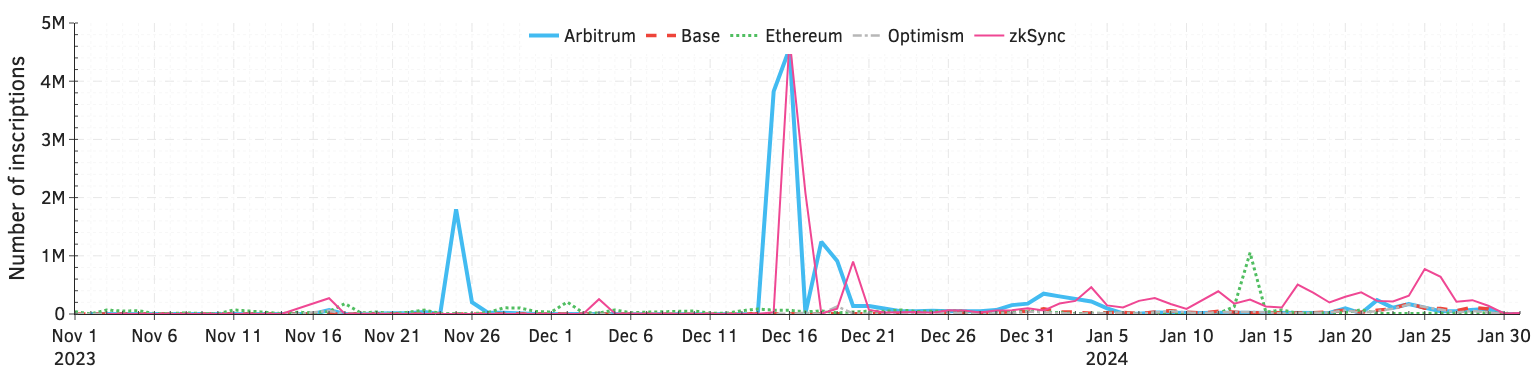

In [9]:
width = 1540
height = 380

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

for protocol, df in inscriptions_per_day_dict.items():
    fig.add_trace(go.Scatter(
        x=df['timestamp'], y=df['tx_hash'],
        line=dict(color=plot_settings[protocol]['color'], width=plot_settings[protocol]
                  ['width'], dash=plot_settings[protocol]['style']),
        name=plot_settings[protocol]['label'],
        marker=dict(size=8, symbol=plot_settings[protocol]['marker_symbol'])
    ))

fig.update_layout(yaxis_title="Number of inscriptions",
                  # xaxis_title="Date",
                  yaxis=dict(range=[0, 5_000_000]),
                  # yaxis=dict(type="log"),
                  xaxis=dict(
                      # tickformat="%Y-%m-%d",  # Customize the format as needed
                      dtick=432000000,  # Set the interval between ticks to one week
                  ),
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))
file_dir = os.path.realpath(os.path.join(
    plots_dir, "fraction-of-inscriptions-all.pdf"))
fig.write_image(file_dir)
fig.show('png')

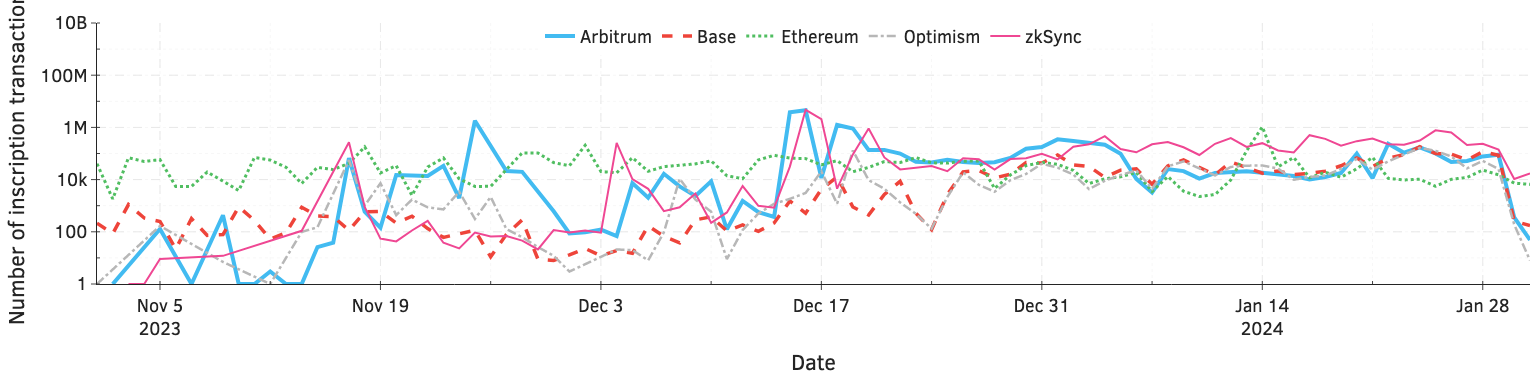

In [10]:
fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

for protocol, df in inscriptions_per_day_dict.items():
    fig.add_trace(go.Scatter(
        x=df['timestamp'], y=df['tx_hash'],
        line=dict(color=plot_settings[protocol]['color'], width=plot_settings[protocol]
                  ['width'], dash=plot_settings[protocol]['style']),
        name=plot_settings[protocol]['label'],
        marker=dict(size=8, symbol=plot_settings[protocol]['marker_symbol'])
    ))

fig.update_layout(yaxis_title="Number of inscription transactions",
                  xaxis_title="Date",
                  yaxis=dict(type="log", range=[0, 10]),
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

file_dir = os.path.realpath(os.path.join(
    plots_dir, "fraction-of-inscriptions-all-log.pdf"))
fig.write_image(file_dir)
fig.show('png')

In [11]:
url = 'https://api.growthepie.xyz/v1/fundamentals_full.json'
response = requests.get(url)
df = pd.DataFrame(response.json())

tx_count_data = {}  # Dictionary to store tx count data for each chain

for chain in chains:
    # Filter data based on conditions
    key = chain
    if (chain == 'zksync'):
        key = 'zksync_era'
    filtered_data = df[(df['metric_key'] == 'txcount') &
                       (df['origin_key'] == key) &
                       (df['date'] >= '2023-11-01') &
                       (df['date'] <= '2024-02-01')].sort_values('date')

    # Store filtered data in the dictionary
    tx_count_data[chain] = filtered_data

# Access the tx count data for a specific chain, for example, 'arbitrum'
print(tx_count_data['zksync'])

       metric_key  origin_key        date      value
379062    txcount  zksync_era  2023-11-01   638909.0
379051    txcount  zksync_era  2023-11-02   559121.0
379052    txcount  zksync_era  2023-11-03   655110.0
375892    txcount  zksync_era  2023-11-04   843935.0
378820    txcount  zksync_era  2023-11-05   788116.0
...           ...         ...         ...        ...
381613    txcount  zksync_era  2024-01-28  1410228.0
381614    txcount  zksync_era  2024-01-29  1292901.0
381673    txcount  zksync_era  2024-01-30  1219450.0
381674    txcount  zksync_era  2024-01-31  1468043.0
381675    txcount  zksync_era  2024-02-01  1264291.0

[93 rows x 4 columns]


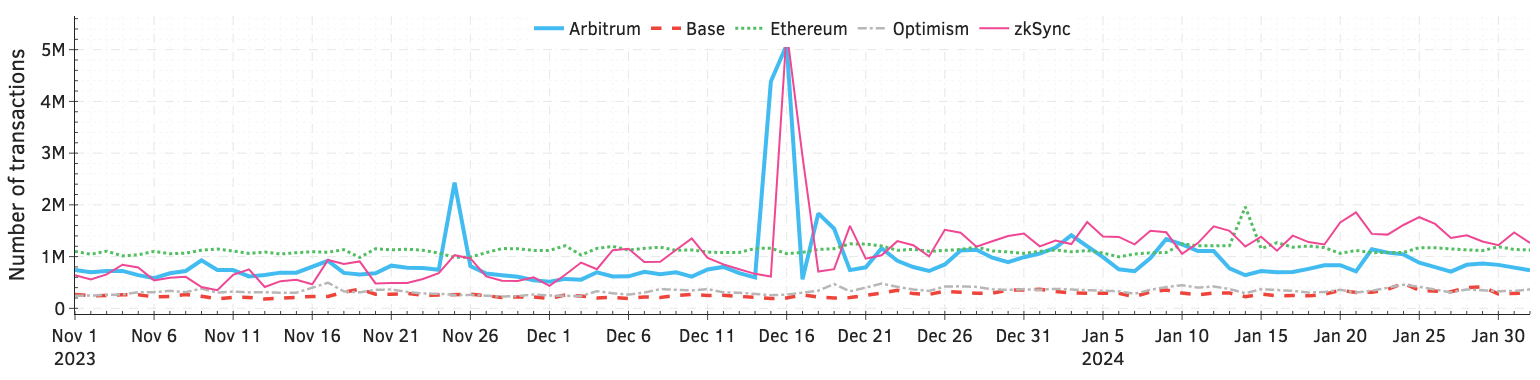

In [12]:
width = 1540
height = 380

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

for protocol, df in tx_count_data.items():
    fig.add_trace(go.Scatter(
        x=df['date'], y=df['value'],
        line=dict(color=plot_settings[protocol]['color'], width=plot_settings[protocol]
                  ['width'], dash=plot_settings[protocol]['style']),
        name=plot_settings[protocol]['label'],
        marker=dict(size=8, symbol=plot_settings[protocol]['marker_symbol'])
    ))

fig.update_layout(yaxis_title="Number of transactions",
                  # xaxis_title="Date",
                  # yaxis=dict(type="log", range=[0, 10]),
                  xaxis=dict(
                      # tickformat="%Y-%m-%d",  # Customize the format as needed
                      dtick=432000000,  # Set the interval between ticks to one week
                  ),
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))

file_dir = os.path.realpath(os.path.join(plots_dir, "all-transactions.pdf"))
fig.write_image(file_dir)
fig.show('png')

In [13]:
import pandas as pd

# Initialize an empty dictionary to store merged DataFrames
merged_dfs = {}

# Iterate over each protocol in chains
for protocol in chains:
    tx_inscription_series = inscriptions_per_day_dict.get(protocol)
    tx_all_series = tx_count_data.get(protocol)

    # Check if both DataFrames exist for the current protocol
    if tx_inscription_series is not None and tx_all_series is not None:
        # Convert Polars DataFrame to Pandas DataFrame
        tx_inscription_series_pd = tx_inscription_series.to_pandas()

        # Convert the 'date' column in tx_all_series to datetime64[us]
        tx_all_series['date'] = pd.to_datetime(tx_all_series['date'])

        # Perform the join operation
        merged_df = pd.merge(tx_inscription_series_pd, tx_all_series,
                             left_on='timestamp', right_on='date', how='inner')

        # Calculate the percentage
        merged_df['percent'] = (merged_df['tx_hash'] /
                                merged_df['value']) * 100

        # Store the merged DataFrame in the dictionary with the protocol as the key
        merged_dfs[protocol] = merged_df
    else:
        print(f"Data not found for protocol: {protocol}")

# Display the merged DataFrames
for protocol, merged_df in merged_dfs.items():
    print(f"Merged DataFrame for {protocol}:")
    print(merged_df)

Merged DataFrame for arbitrum:
    timestamp  tx_hash metric_key origin_key       date     value    percent
0  2023-11-02        1    txcount   arbitrum 2023-11-02  698354.0   0.000143
1  2023-11-05      128    txcount   arbitrum 2023-11-05  641402.0   0.019956
2  2023-11-07        1    txcount   arbitrum 2023-11-07  676865.0   0.000148
3  2023-11-09      431    txcount   arbitrum 2023-11-09  927152.0   0.046486
4  2023-11-10        1    txcount   arbitrum 2023-11-10  742548.0   0.000135
..        ...      ...        ...        ...        ...       ...        ...
82 2024-01-27    51592    txcount   arbitrum 2024-01-27  709749.0   7.269049
83 2024-01-28    77395    txcount   arbitrum 2024-01-28  841050.0   9.202188
84 2024-01-29    89429    txcount   arbitrum 2024-01-29  868161.0  10.300970
85 2024-01-30      357    txcount   arbitrum 2024-01-30  840086.0   0.042496
86 2024-01-31       49    txcount   arbitrum 2024-01-31  791808.0   0.006188

[87 rows x 7 columns]
Merged DataFrame for b

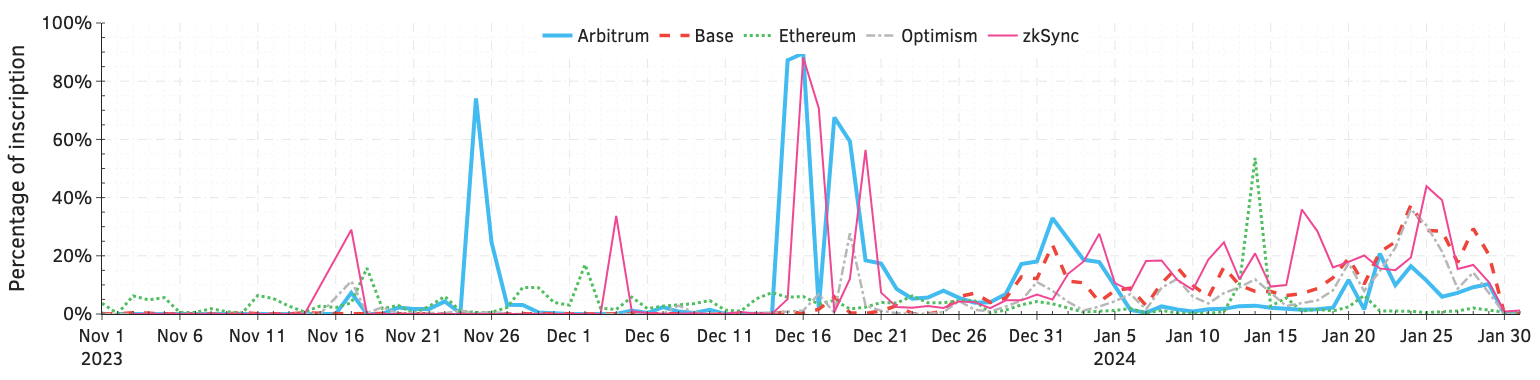

In [14]:
width = 1540
height = 380

fig = go.Figure(layout=get_plotly_layout(width=width, height=height))

for protocol, df in merged_dfs.items():
    fig.add_trace(go.Scatter(
        x=df['timestamp'], y=df['percent'],
        line=dict(color=plot_settings[protocol]['color'], width=plot_settings[protocol]
                  ['width'], dash=plot_settings[protocol]['style']),
        name=plot_settings[protocol]['label'],
        marker=dict(size=8, symbol=plot_settings[protocol]['marker_symbol'])
    ))

fig.update_layout(yaxis_title="Percentage of inscription",
                  # xaxis_title="Date",
                  yaxis=dict(range=[0, 100]),
                  # yaxis=dict(type="log"),
                  yaxis_ticksuffix="%",
                  xaxis=dict(
                      # tickformat="%Y-%m-%d",  # Customize the format as needed
                      dtick=432000000,  # Set the interval between ticks to one week
                  ),
                  legend=dict(xanchor='center', x=0.5, y=1.02, orientation='h'))
file_dir = os.path.realpath(os.path.join(plots_dir, "percent-of-inscriptions-all.pdf"))
fig.write_image(file_dir)
fig.show('png')

In [15]:
highest_percent_dates = {}

for protocol, df in merged_dfs.items():
    max_percent_row = df.loc[df['percent'].idxmax()]
    highest_percent_dates[protocol] = {
        'date': max_percent_row['timestamp'],
        'percent': max_percent_row['percent']
    }

# Print the dates with the highest percentage for each protocol
for protocol, data in highest_percent_dates.items():
    print(
        f"Protocol: {protocol}, Date: {data['date']}, Percent: {data['percent']}")

Protocol: arbitrum, Date: 2023-12-16 00:00:00, Percent: 89.62555529140396
Protocol: base, Date: 2024-01-24 00:00:00, Percent: 37.44728061635109
Protocol: ethereum, Date: 2024-01-14 00:00:00, Percent: 53.63848855565935
Protocol: optimism, Date: 2024-01-24 00:00:00, Percent: 35.967787430275706
Protocol: zksync, Date: 2023-12-16 00:00:00, Percent: 88.17194957747839
